In [1]:
import pandas as pd
import os
import gc
import time
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform

## Read Data

In [2]:
path='C:/Users/yiming.xu/Downloads/20220905-20220919'

In [4]:
len(os.listdir(path))

501

cols = ['grid', 'latitude', 'longitude', 'timestamp', 'timezone','ipaddress', 'forensicflag', 'devicetype', 'recordcount']

In [4]:
# myfile = 'part_0.csv.gz'
# data = pd.read_csv(os.path.join(path,myfile),sep='|',header=None)
# data.drop_duplicates([0,3], inplace=True)

In [11]:
def extract_data(file, start = pd.Timestamp('2022-09-12T00'), end = pd.Timestamp('2022-09-16T00')):
    df = pd.read_csv(file, sep='|', header=None)
    df['time'] = pd.to_datetime(df[3], unit='ms')
    df = df[(df['time'] >= start) & (df['time'] < end)]
    return df

def record_count(data):
    len_0 = data.shape[0]
    print('Number of records: ', len_0)
    data.drop_duplicates([0,3], inplace=True)
    len_1 = data.shape[0]
    print('Duplicated records: ', len_0 - len_1)
    print('Records after dropping duplicates: ', len_1)
    deviceID = data[0].unique()
    print('Unique ID: ',len(deviceID))
    print('Time Range: ', data['time'].min(), 'to', data['time'].max())

In [12]:
# data = extract_data(os.path.join(path,myfile))
data = pd.concat([extract_data(os.path.join(path,myfile)) for myfile in os.listdir(path)[:5]])
record_count(data)

Number of records:  11567612
Duplicated records:  1689499
Records after dropping duplicates:  9878113
Unique ID:  88653
Time Range:  2022-09-12 00:00:00 to 2022-09-15 23:59:59


In [13]:
data.head()

,0,1,2,3,4,5,6,7,8,time
0,0012be41-102e-3759-9298-78a85b634368,28.417551,-81.460846,1663158728000,America/New_York,96.47.146.0,33587200,NaN,12,2022-09-14 12:32:08
1,0012be41-102e-3759-9298-78a85b634368,28.417562,-81.460835,1663158778000,America/New_York,104.129.196.45,33587200,NaN,5,2022-09-14 12:32:58
2,0012be41-102e-3759-9298-78a85b634368,28.417551,-81.460846,1663158785000,America/New_York,96.47.146.0,33554432,NaN,2,2022-09-14 12:33:05
3,0012be41-102e-3759-9298-78a85b634368,28.417551,-81.460846,1663158819000,America/New_York,96.47.146.0,33587200,NaN,11,2022-09-14 12:33:39
4,0012be41-102e-3759-9298-78a85b634368,28.417562,-81.460835,1663158829000,America/New_York,96.47.146.0,33587200,NaN,8,2022-09-14 12:33:49


## Record Count

In [14]:
count=data.groupby(0).count()

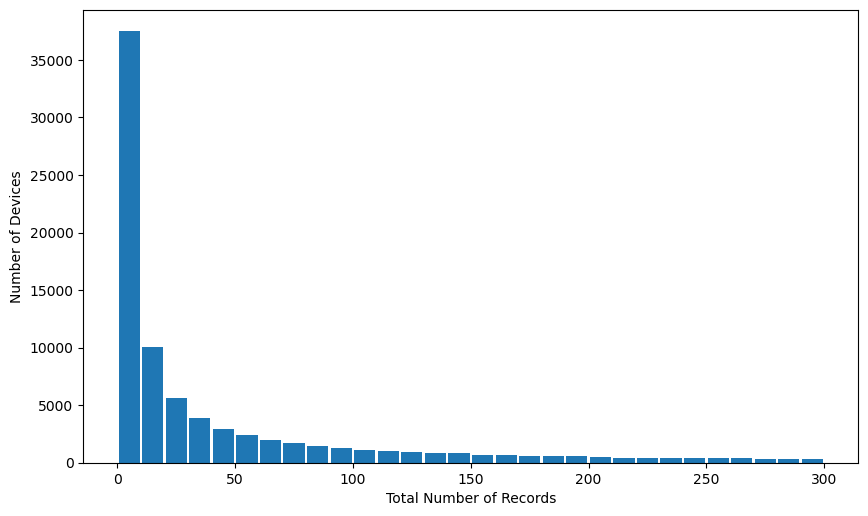

In [15]:
plt.figure(figsize=[10,6],dpi=100)
plt.hist(count.iloc[:,0],range=[0,300],bins=30,rwidth=0.9)
plt.xlabel('Total Number of Records')
plt.ylabel('Number of Devices')
plt.show()

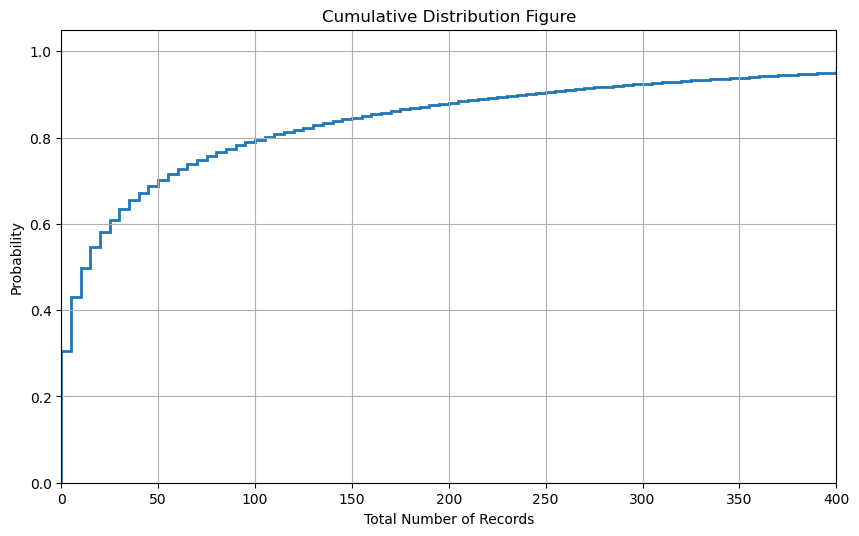

In [16]:
plt.figure(figsize=[10,6],dpi=100)
plt.hist(count.iloc[:,0],range=[0,1000],bins=200,histtype='step',cumulative=True,density=True,linewidth=2)
plt.xlabel('Total Number of Records')
plt.ylabel('Probability')
plt.xlim(0,400)
plt.title('Cumulative Distribution Figure')
plt.grid()
plt.show()

## Daily Active User

In [20]:
ts = pd.date_range(pd.Timestamp('2022-09-12T00'),pd.Timestamp('2022-09-16T00'),freq='D')

In [21]:
gc.collect()

2877

In [22]:
ts

DatetimeIndex(['2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15',
               '2022-09-16'],
              dtype='datetime64[ns]', freq='D')

In [23]:
dic = dict()
for i in range(4):
    dic['day_{}'.format(i)]=data[(data['time']<ts[i+1])&(data['time']>=ts[i])]
    dic['unique_{}'.format(i)]=dic['day_{}'.format(i)][0].unique()
    dic['count_{}'.format(i)]=dic['day_{}'.format(i)].groupby(0).count().iloc[:,0]

In [27]:
def signal_count(threshold,dic):
    temp=dic['count_0'][dic['count_0']>=threshold]
    for i in range(1,4):
        temp=pd.merge(temp,dic['count_{}'.format(i)][dic['count_{}'.format(i)]>=threshold],
                      left_index=True, right_index=True,how='inner')
    print('Devices with at least ', threshold ,' signals everyday: ',temp.shape[0])

In [30]:
print('Total Number of Unique Devices: ',len(data[0].unique()))
for i in [1,10,20,30,40,50,60,70,80,90,100]:
    signal_count(i,dic)

Total Number of Unique Devices:  88653
Devices with at least  1  signals everyday:  35674
Devices with at least  10  signals everyday:  18882
Devices with at least  20  signals everyday:  13468
Devices with at least  30  signals everyday:  10398
Devices with at least  40  signals everyday:  8297
Devices with at least  50  signals everyday:  6787
Devices with at least  60  signals everyday:  5706
Devices with at least  70  signals everyday:  4833
Devices with at least  80  signals everyday:  4154
Devices with at least  90  signals everyday:  3614
Devices with at least  100  signals everyday:  3156


## Spatial Distribution

In [31]:
import geopandas as gpd
import contextily as ct

In [40]:
census = gpd.read_file('zip://C:/Users/yiming.xu/0_Python_Code/USA_Counties_(Generalized).zip')

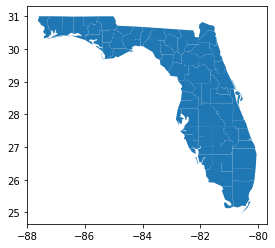

In [44]:
census = census[census['STATE_FIPS']=='12']
census.plot()

In [47]:
temp = data.iloc[:100,:]

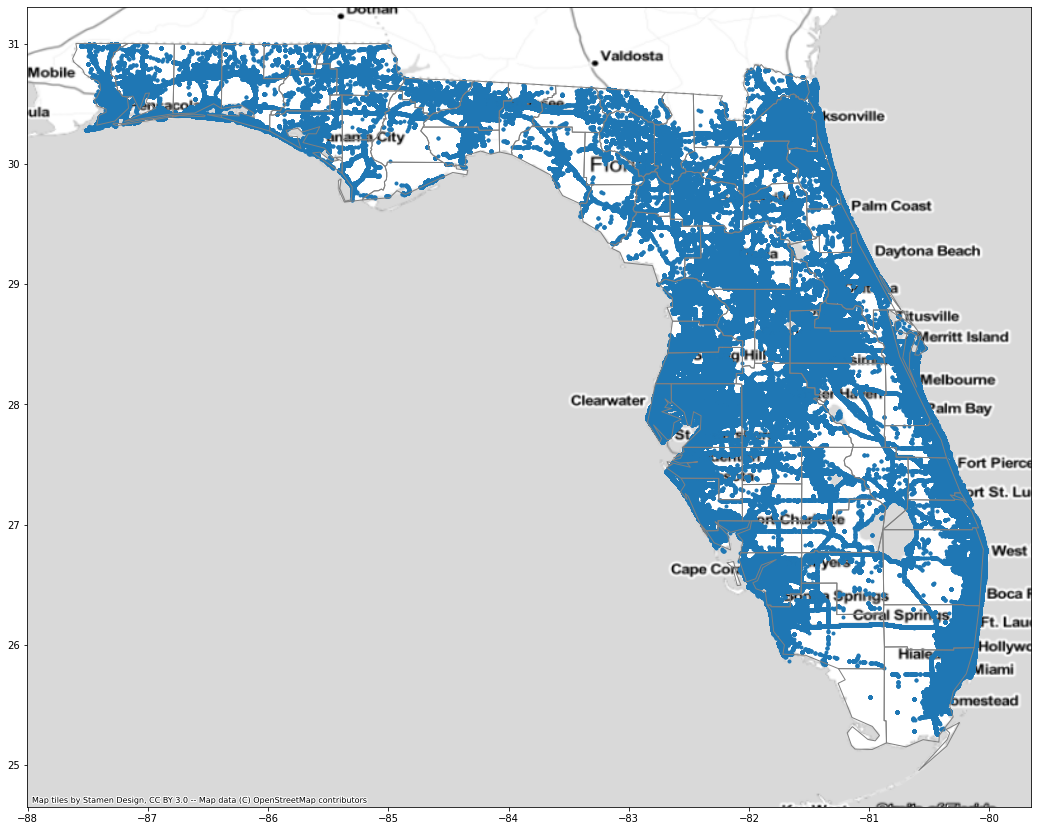

In [72]:
fig, ax = plt.subplots(1, 1, figsize = (18,18))
census.plot(ax = ax, color = 'none', edgecolor = 'grey', zorder = 3)
ax.plot(data[2],data[1], '.')
ct.add_basemap(ax, crs = 'EPSG:4326', source= ct.providers.Stamen.TonerLite)